In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 

In [2]:

num_gpu = []
num_gpu_avg = []
num_client = []
num_client_avg = []
avg_detect_time = []
avg_detect_time_avg = []

In [3]:
filename = 'num_gpu-num_client-detection_time.csv'
df = pd.read_csv(filename)
print(df.head())

   Num GPU  Num Client  Round  Average Detection Time      Average
0        1          10      1                 1359187  1188845.333
1        1          10      2                 1065631  1188845.333
2        1          10      3                 1141718  1188845.333
3        1          20      1                 1489995  1763402.000
4        1          20      2                 1648619  1763402.000


In [4]:
for index, row in df.iterrows():
    num_gpu.append(row['Num GPU'])
    num_client.append(row['Num Client'])
    avg_detect_time.append(row['Average Detection Time']/1000)
    if index % 3 == 0:
        num_gpu_avg.append(row['Num GPU'])
        num_client_avg.append(row['Num Client'])
        avg_detect_time_avg.append(row['Average']/1000)

/tmp/ipykernel_4158184/542949270.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


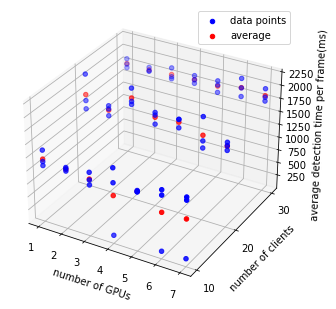

In [5]:

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(num_gpu, num_client, avg_detect_time, c='b', label='data points')
ax.scatter(num_gpu_avg, num_client_avg, avg_detect_time_avg, c='r', label='average')
ax.legend(loc='best')
ax.set_zlabel('average detection time per frame(ms)')
ax.set_xlabel('number of GPUs')
ax.set_ylabel('number of clients')
ax.set_yticks([10, 20, 30])
plt.show()

In [6]:
# fitting
a = 0
A = np.ones((len(avg_detect_time),3))
for i in range(0, len(avg_detect_time)):
    A[i, 0] = num_gpu[a]
    A[i, 1] = num_client[a]
    a += 1

b = np.zeros((len(avg_detect_time), 1))
a = 0
for i in range(0, len(avg_detect_time)):
    b[i, 0] = avg_detect_time[a]
    a += 1

A_T = A.T
A1 = np.dot(A_T,A)
A2 = np.linalg.inv(A1)
A3 = np.dot(A2,A_T)
X= np.dot(A3, b)
print('palne fitting result：z = %.3f * x + %.3f * y + %.3f'%(X[0,0],X[1,0],X[2,0]))
R=0
for i in range(0,len(avg_detect_time)):
    R=R+(X[0, 0] * num_gpu[i] + X[1, 0] * num_client[i] + X[2, 0] - avg_detect_time[i])**2
print ('variance is: %.*f'%(3,R))

palne fitting result：z = -20.192 * x + 38.390 * y + 818.324
variance is: 5123882.918


/tmp/ipykernel_4158184/3603220499.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


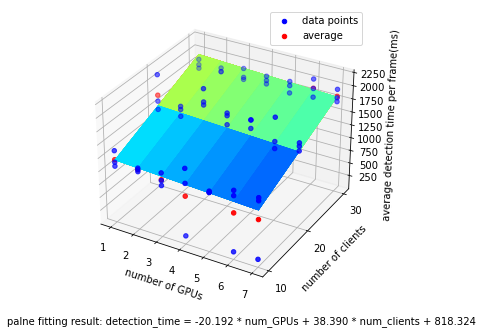

In [7]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(num_gpu, num_client, avg_detect_time, c='b', label='data points')
ax.scatter(num_gpu_avg, num_client_avg, avg_detect_time_avg, c='r', label='average')
x_p, y_p = np.meshgrid(num_gpu, num_client)
z_p = X[0, 0] * x_p + X[1, 0] * y_p + X[2, 0]
ax.plot_surface(x_p, y_p, z_p, cmap=cm.jet, rstride=1, cstride=1)
ax.legend(loc='best')
ax.set_zlabel('average detection time per frame(ms)')
ax.set_xlabel('number of GPUs')
ax.set_ylabel('number of clients')
ax.set_title('')
ax.set_yticks([10, 20, 30])
ax.text2D(-0.25, -0.1, 'palne fitting result: detection_time = %.3f * num_GPUs + %.3f * num_clients + %.3f'%(X[0,0],X[1,0],X[2,0]), transform=ax.transAxes)
plt.show()

In [8]:
# regression
from sklearn.linear_model import LinearRegression
gpu_client = [[num_gpu[i], num_client[i]] for i in range(len(num_gpu))]
model = LinearRegression()
model.fit(gpu_client, avg_detect_time)

LinearRegression()

/tmp/ipykernel_4158184/3845978144.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


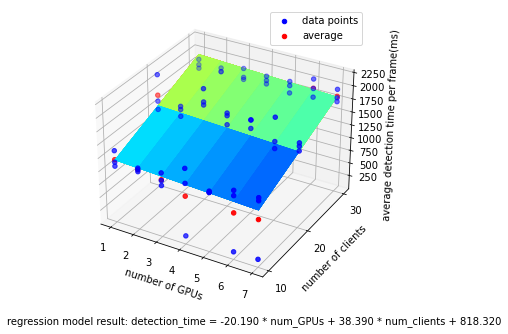

In [9]:
coe = model.coef_
intercept = model.intercept_
equation =  "detection time = " + str(round(coe[0],2)) + "*num_GPUs + " + str(round(coe[1],2)) + "*num_clients +" + str(round(intercept,2))

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(num_gpu, num_client, avg_detect_time, c='b', label='data points')
ax.scatter(num_gpu_avg, num_client_avg, avg_detect_time_avg, c='r', label='average')
x_p, y_p = np.meshgrid(num_gpu, num_client)
z_p = round(coe[0],2) * x_p + round(coe[1],2) * y_p + round(intercept,2)
ax.plot_surface(x_p, y_p, z_p, cmap=cm.jet, rstride=1, cstride=1)
ax.legend(loc='best')
ax.set_zlabel('average detection time per frame(ms)')
ax.set_xlabel('number of GPUs')
ax.set_ylabel('number of clients')
ax.set_yticks([10, 20, 30])
ax.set_title('')
ax.text2D(-0.25, -0.1, 'regression model result: detection_time = %.3f * num_GPUs + %.3f * num_clients + %.3f'%(round(coe[0],2),round(coe[1],2),round(intercept,2)), transform=ax.transAxes)
plt.show()

In [10]:
# calculate variation
R=0
num_records = 0
for i in range(0,len(avg_detect_time)):
    R=R+( coe[0] * 1 / num_gpu[i] + coe[1] * num_client[i] + intercept - avg_detect_time[i])**2
    num_records += 1
R = R / num_records
print ('variance is: %.*f'%(3,R))

variance is: 88727.012


In [11]:
# regression (inverse GPU)
from sklearn.linear_model import LinearRegression
inverse_gpu_client = [[1.0 / num_gpu[i], num_client[i]] for i in range(len(num_gpu))]
inverse_model = LinearRegression()
inverse_model.fit(inverse_gpu_client, avg_detect_time)

LinearRegression()

/tmp/ipykernel_4158184/1879520651.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


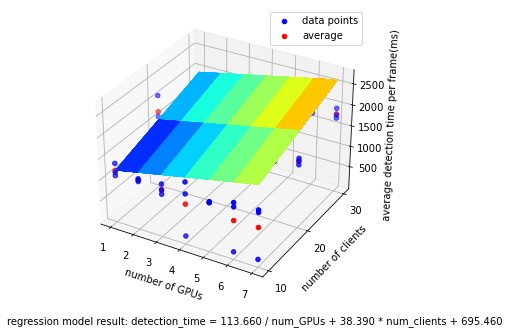

In [12]:
coe = inverse_model.coef_
intercept = inverse_model.intercept_
equation =  "detection time = " + str(round(coe[0],2)) + "/num_GPUs + " + str(round(coe[1],2)) + "*num_clients +" + str(round(intercept,2))

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(num_gpu, num_client, avg_detect_time, c='b', label='data points')
ax.scatter(num_gpu_avg, num_client_avg, avg_detect_time_avg, c='r', label='average')
x_p, y_p = np.meshgrid(num_gpu, num_client)
z_p = round(coe[0],2) * x_p + round(coe[1],2) * y_p + round(intercept,2)
ax.plot_surface(x_p, y_p, z_p, cmap=cm.jet, rstride=1, cstride=1)
ax.legend(loc='best')
ax.set_zlabel('average detection time per frame(ms)')
ax.set_xlabel('number of GPUs')
ax.set_ylabel('number of clients')
ax.set_yticks([10, 20, 30])
ax.set_title('')
ax.text2D(-0.25, -0.1, 'regression model result: detection_time = %.3f / num_GPUs + %.3f * num_clients + %.3f'%(round(coe[0],2),round(coe[1],2),round(intercept,2)), transform=ax.transAxes)
plt.show()

In [13]:
# calculate variation
R=0
num_records = 0
for i in range(0,len(avg_detect_time)):
    R=R+( coe[0] * 1 / num_gpu[i] + coe[1] * num_client[i] + intercept - avg_detect_time[i])**2
    num_records += 1
R = R / num_records
print ('variance is: %.*f'%(3,R))

variance is: 81944.649
